# Working with Unlabeled Data – Cluster Analysis
Find the best number of clusters with __k_means__ and __agglomerative clustering__

## Overview

1. Load the data file
    - check the shape and plot the content  
1. Observe the pair plot and comment the shapes in view of clustering 
    1. if necessary, transform the data
1. Use the elbow method to find the optimal number of clusters, to do this test `KMeans` with varying number of clusters, from 2 to 10: for each value of `k` 
    - fit the data
    - compute the __inertia__ and the __silhouette score__  
    - store them for plot
1. Plot inertia and silhouette score versus `k`
1. Choose the optimal number of clusters looking at the plots
1. Cluster the data using the optimal number, plot the cluster assignment 
    - in the plot choose the features that seem to be most promising
1. For comparison, repeat the same operation with the `AgglomerativeClustering` and `DBSCAN`
        

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from mpl_toolkits import mplot3d
from sklearn.model_selection import ParameterGrid
import warnings

# warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8")

random_state = 42
np.random.seed(random_state)

## 1. Load the data file
Check the shape and plot the content 

In [2]:
X_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv"
delimiter = ","
X0 = pd.read_csv(X_url, delimiter=delimiter)
X0.shape

(440, 8)

In [3]:
X0.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
X0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [5]:
# Sum of the count of null objects in all columns of data frame
np.sum(pd.isnull(X0).sum())

0

## 2. Observe the data distributions

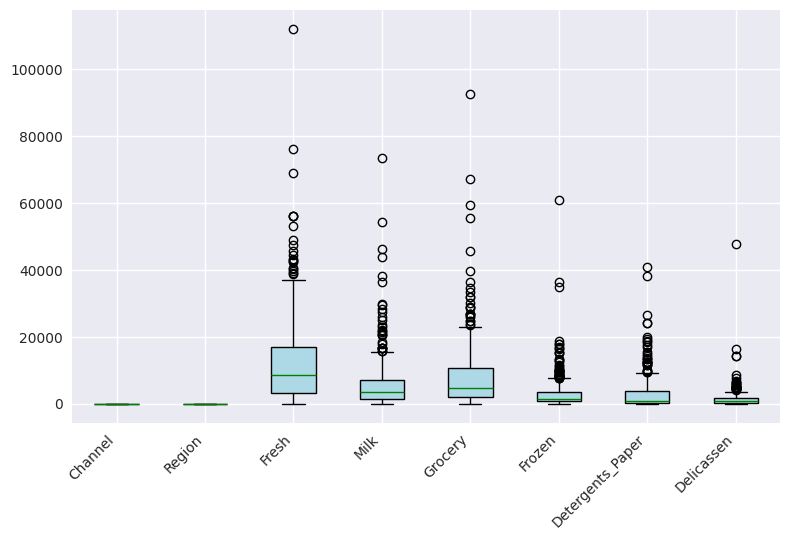

In [6]:
plt.boxplot(
    X0,
    labels=X0.columns,
    patch_artist=True,
    flierprops={"markeredgecolor": "k"},
    whiskerprops={"color": "k"},
    capprops={"color": "k"},
    medianprops={"color": "green"},
    boxprops={"color": "k", "facecolor": "lightblue"},
)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

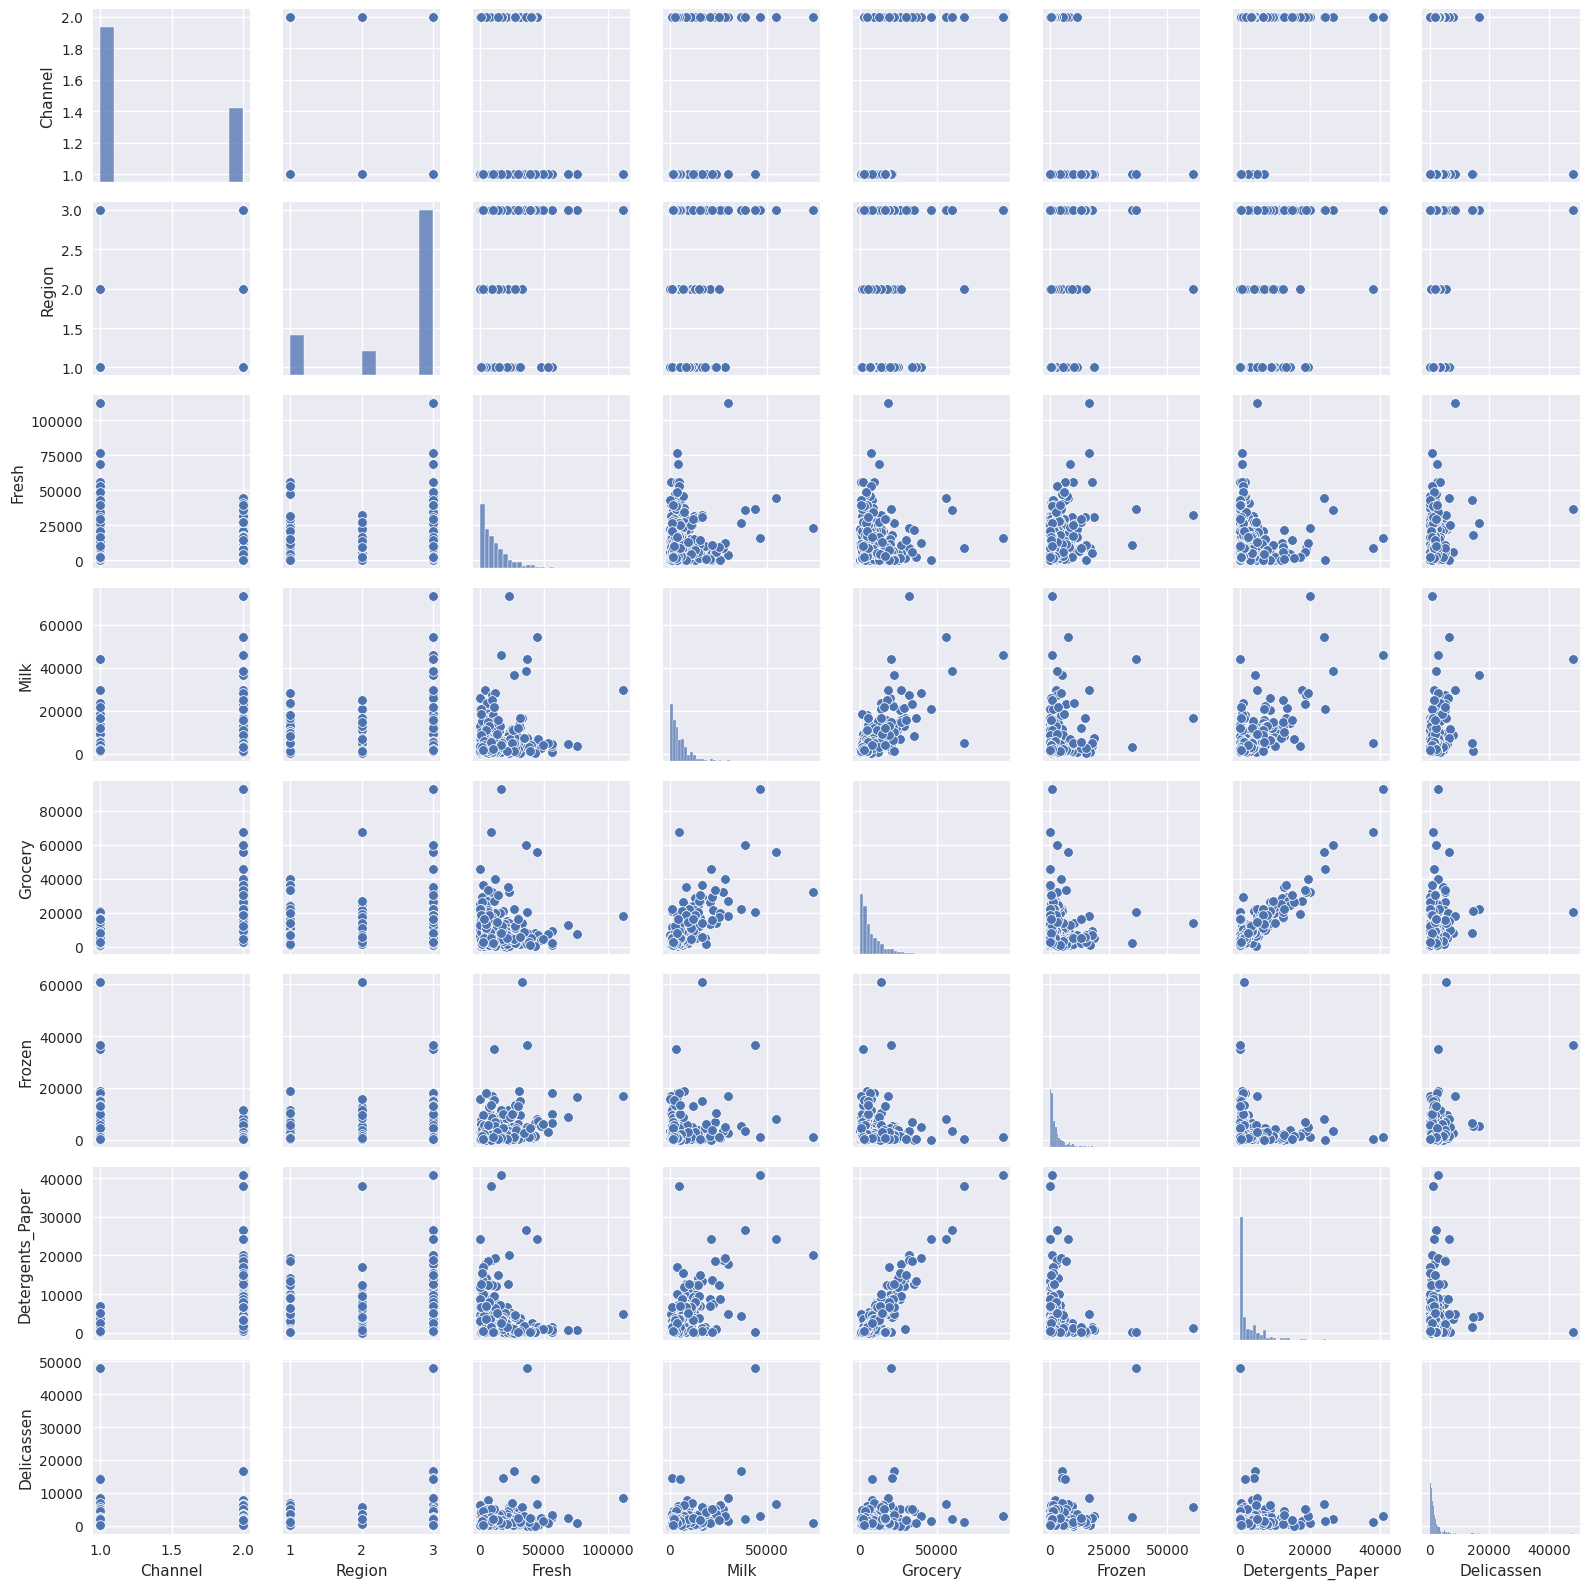

In [7]:
sns.pairplot(X0, height=2, diag_kind="hist")
plt.tight_layout()
plt.show()

We observe that the distributions of values are definitely *skewed*: in the columns from `Fresh` to `Delicassen` the values are highly concentrated on the right, but there are always outliers, frequently in a very large range.

Clustering is more effective in absence of outliers and with all the variables distributed in similar ranges, for this reason, we will execute two transformations:
1. transform all the variables from the column `Fresh` to the column `Delicassen` with [PowerTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html)
1. remap all the variables in the range `0:1`

In [8]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler

X_pt = X0.copy()
X_pt.iloc[:, 2:8] = PowerTransformer(copy=False).fit_transform(X0.iloc[:, 2:8])
X_pt = pd.DataFrame(MinMaxScaler().fit_transform(X_pt), columns=X0.columns)
X_pt.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,1.0,1.0,0.501828,0.667606,0.625238,0.208640,0.649941,0.412016
1,1.0,1.0,0.414266,0.670028,0.655690,0.458800,0.674852,0.445663
2,1.0,1.0,0.400077,0.653586,0.627297,0.499856,0.682752,0.654292
3,0.0,1.0,0.509368,0.369264,0.553550,0.636716,0.461095,0.446485
4,1.0,1.0,0.604755,0.580657,0.618985,0.566470,0.601884,0.590255


Show the result of the transformation

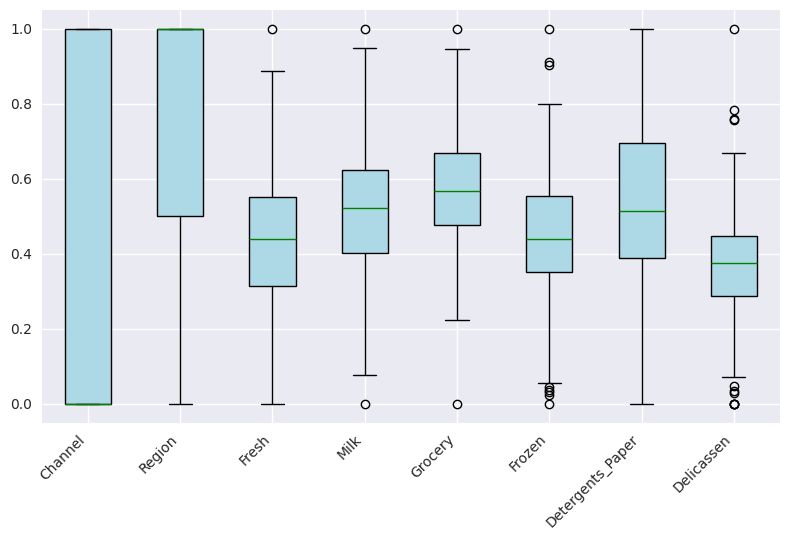

In [9]:
plt.boxplot(
    X_pt,
    labels=X0.columns,
    patch_artist=True,
    flierprops={"markeredgecolor": "k"},
    whiskerprops={"color": "k"},
    capprops={"color": "k"},
    medianprops={"color": "green"},
    boxprops={"color": "k", "facecolor": "lightblue"},
)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

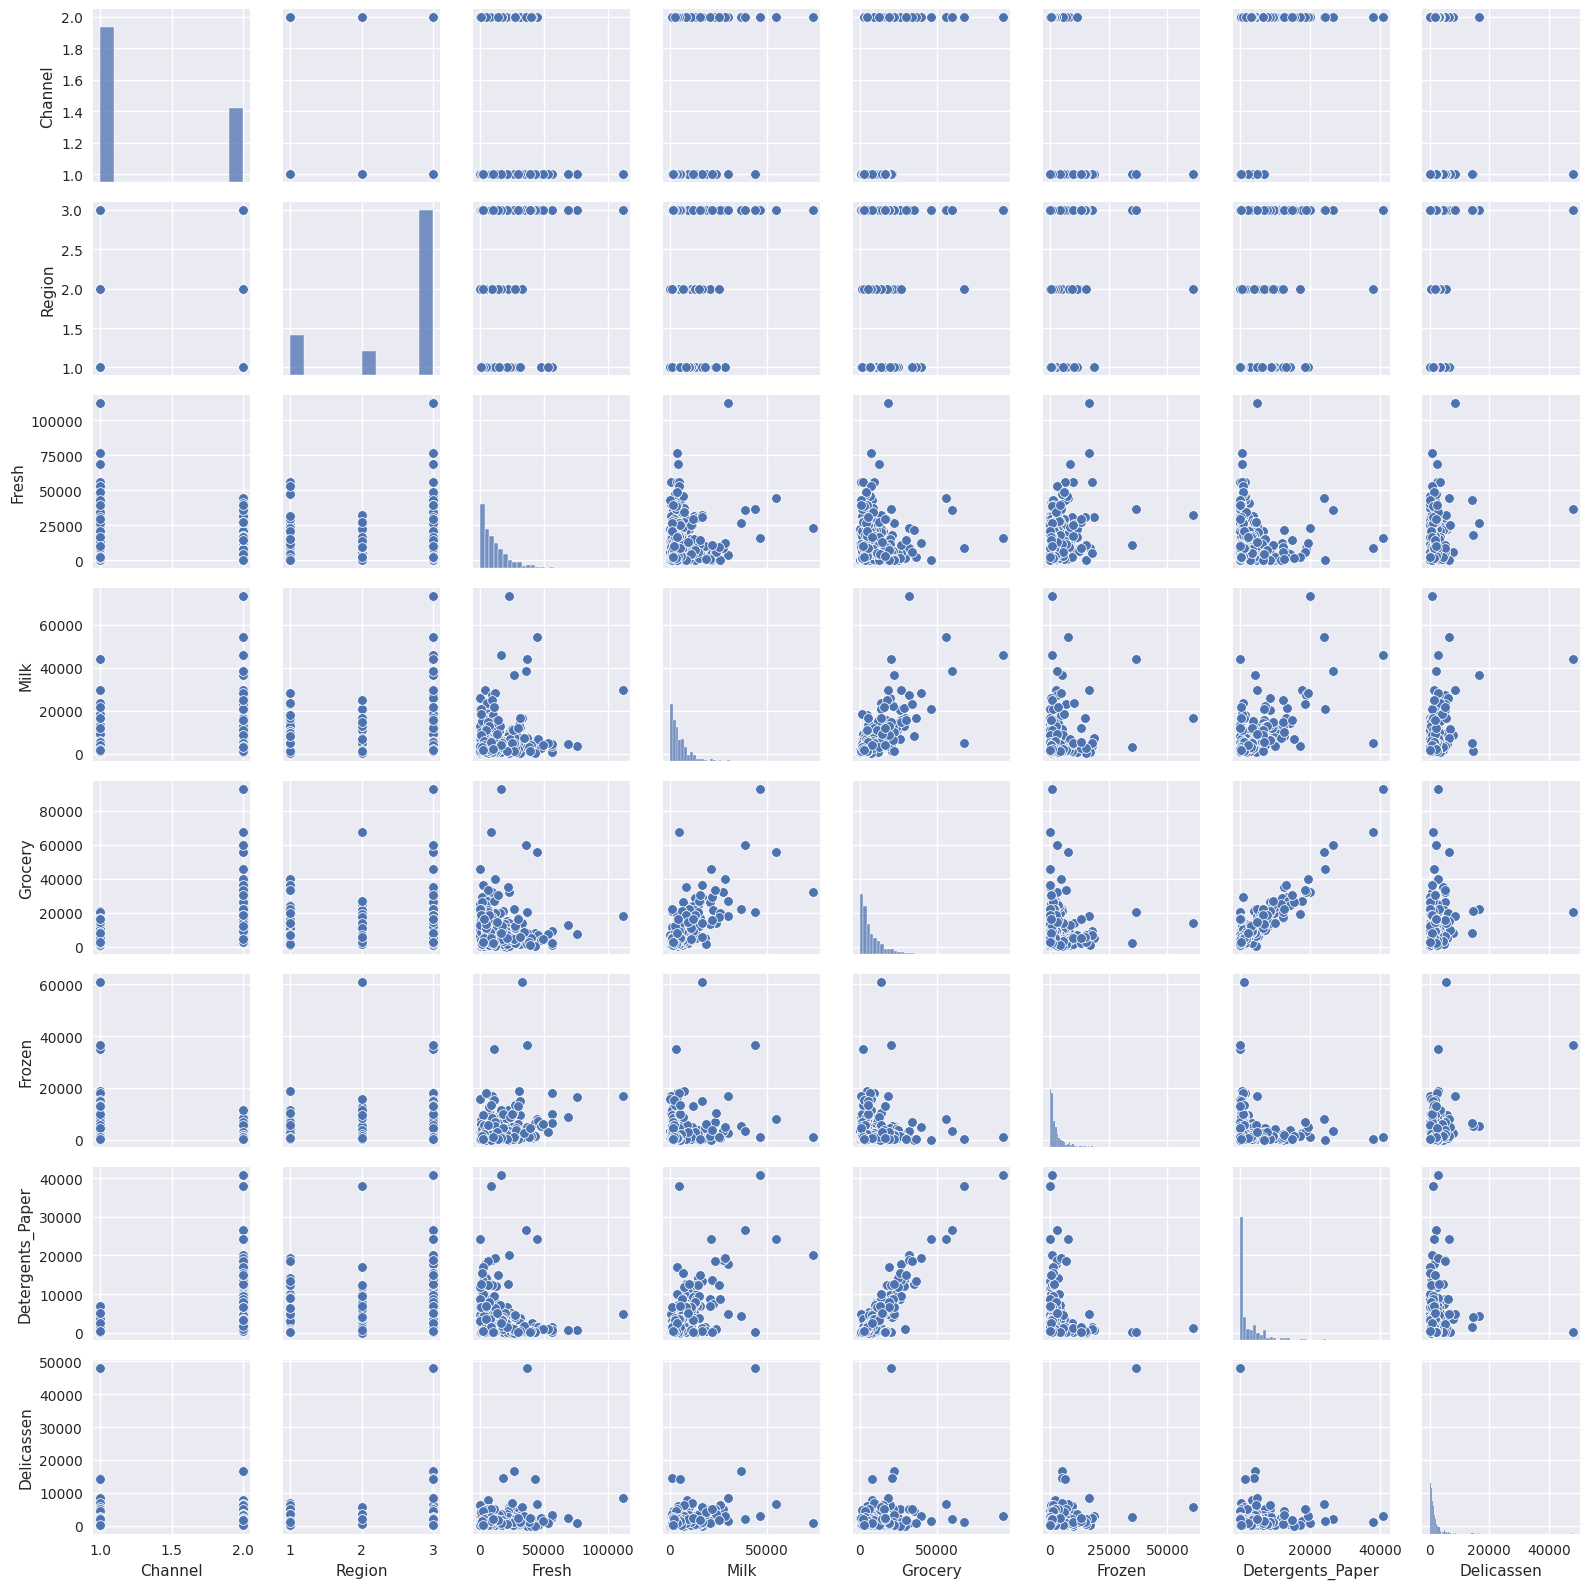

In [10]:
sns.pairplot(X0, height=2, diag_kind="hist")
plt.tight_layout()
plt.show()

Now the effect of outliers is reduced, and we compute the clustering

## 3. Use the elbow method to find the optimal number of clusters
Test `KMeans` with varying number of clusters, from 2 to 10

Prepare the results list that will contain pairs of `inertia` and `silhouette_score` for each value of `k`, then, __for each value__ of `k` 
- initialize an estimator for `KMeans`
- fit the data and predict the cluster assignment for each individual with `fit` and `predict`
- the __inertia__ is provided in the attribute `inertia_` of the fitted model
- compute the __silhouette score__  using the function `silhouette_score` from `sklearn.metrics` using as arguments the data and the fitted labels, we will fill the variable `silhouette_scores`
- store the two values above in the list created at the beginning

In [11]:
results = pd.DataFrame(columns=["inertia", "silhouette_score"])
for k in range(2, 11):
    kmeans = KMeans(
        n_clusters=k,
        init="k-means++",
        max_iter=300,
        n_init=10,
        random_state=random_state,
    )
    pred_k = kmeans.fit_predict(X_pt)
    silhouette_scores = silhouette_score(X_pt, pred_k)
    results.loc[len(results)] = {
        "inertia": kmeans.inertia_,
        "silhouette_score": silhouette_scores,
    }

## 4. Plot __inertia__ and __silhouette score__ versus `k`

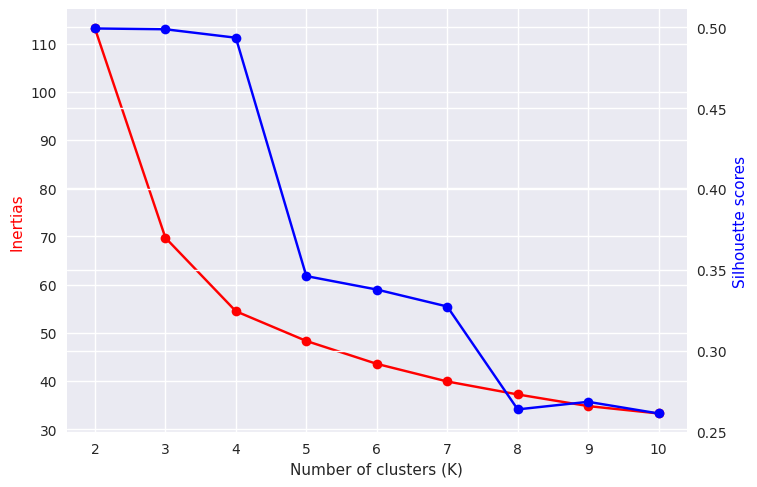

In [12]:
fig, ax1 = plt.subplots()

# Inertia
ax1.plot(range(2, 11), results["inertia"], "ro-")
ax1.set_xlabel("Number of clusters (K)")
ax1.set_ylabel("Inertias", color="red")

# silhouette score
ax2 = ax1.twinx()
ax2.plot(range(2, 11), results["silhouette_score"], "bo-")
ax2.set_ylabel("Silhouette scores", color="blue")

plt.show()

## 5. Cluster with the optimal number
The two *elbow* points of inertia would suggest as cluster number 3 or 4, slightly more pronounced in 3. Silhouette has a maximum on 4, but the increase with respect to 3 is very small.

We will choose k=4

In [13]:
kmeans = KMeans(
    n_clusters=4,
    init="k-means++",
    max_iter=300,
    n_init=10,
    random_state=random_state,
)
pred_k = kmeans.fit_predict(X_pt)

print(
    "Distortion: {:.2f}, Silhouette: {:.2f}".format(
        kmeans.inertia_, silhouette_score(X_pt, pred_k)
    )
)

Distortion: 54.49, Silhouette: 0.49


Show the distribution of samples in the clusters with a pie chart

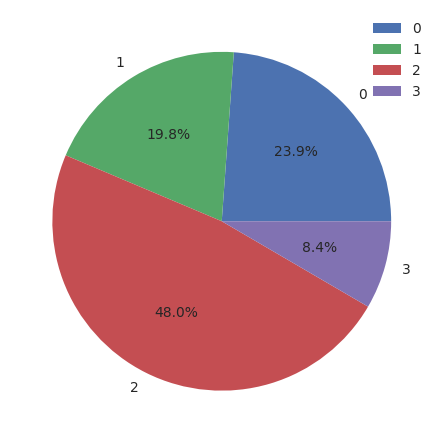

In [14]:
plt.pie(
    np.unique(pred_k, return_counts=True)[1],
    labels=np.unique(pred_k, return_counts=True)[0],
    autopct="%1.1f%%",
)
plt.legend()
plt.show()

### Comments
The __silhouette score__ ranges from `-1` (worst) to `1` (best); as a rule of thumb, a value greater than `0.5` should be considered acceptable.

## Agglomerative clustering
We will try a grid of parameter configurations, with the number of clusters in the range `2:10` and the four linkage methods available in the *sklearn* implementation of *AgglomerativeClustering*. 

In [15]:
from sklearn.cluster import AgglomerativeClustering

results = pd.DataFrame(columns=["linkage", "n", "silhouette_score"])
for n in range(2, 11):
    for linkage in ["ward", "complete", "average", "single"]:
        clustering = AgglomerativeClustering(n_clusters=n, linkage=linkage)
        pred_clu = clustering.fit_predict(X_pt)
        silhouette_scores = silhouette_score(X_pt, pred_clu)
        results.loc[len(results)] = {
            "linkage": linkage,
            "n": n,
            "silhouette_score": silhouette_scores,
        }

In [16]:
results.sort_values(by="silhouette_score", ascending=False)

,linkage,n,silhouette_score
0,ward,2,0.499350
1,complete,2,0.499350
2,average,2,0.499350
3,single,2,0.499350
4,ward,3,0.498333
8,ward,4,0.493085
9,complete,4,0.479507
10,average,4,0.479507
14,average,5,0.475050
18,average,6,0.443867


The top five results have a very similar silhouette score, we will choose the setting with 4 clusters, as for k-means, and the linkage giving the best result with 4 clusters, that is `ward`. This is the result record with `index 2` (the record index is the unnamed column at the very left of the dataframe output

In [17]:
results.iloc[8, :]

linkage                 ward
n                          4
silhouette_score    0.493085
Name: 8, dtype: object

In [18]:
clustering = AgglomerativeClustering(n_clusters=4, linkage="ward")
pred_clu = clustering.fit_predict(X_pt)

Show the distribution of data in the clusters

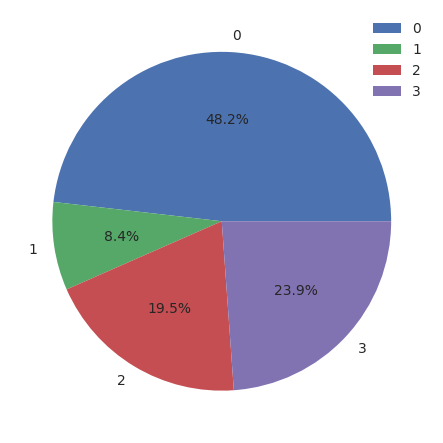

In [19]:
plt.pie(
    np.unique(pred_clu, return_counts=True)[1],
    labels=np.unique(pred_clu, return_counts=True)[0],
    autopct="%1.1f%%",
)
plt.legend()
plt.show()

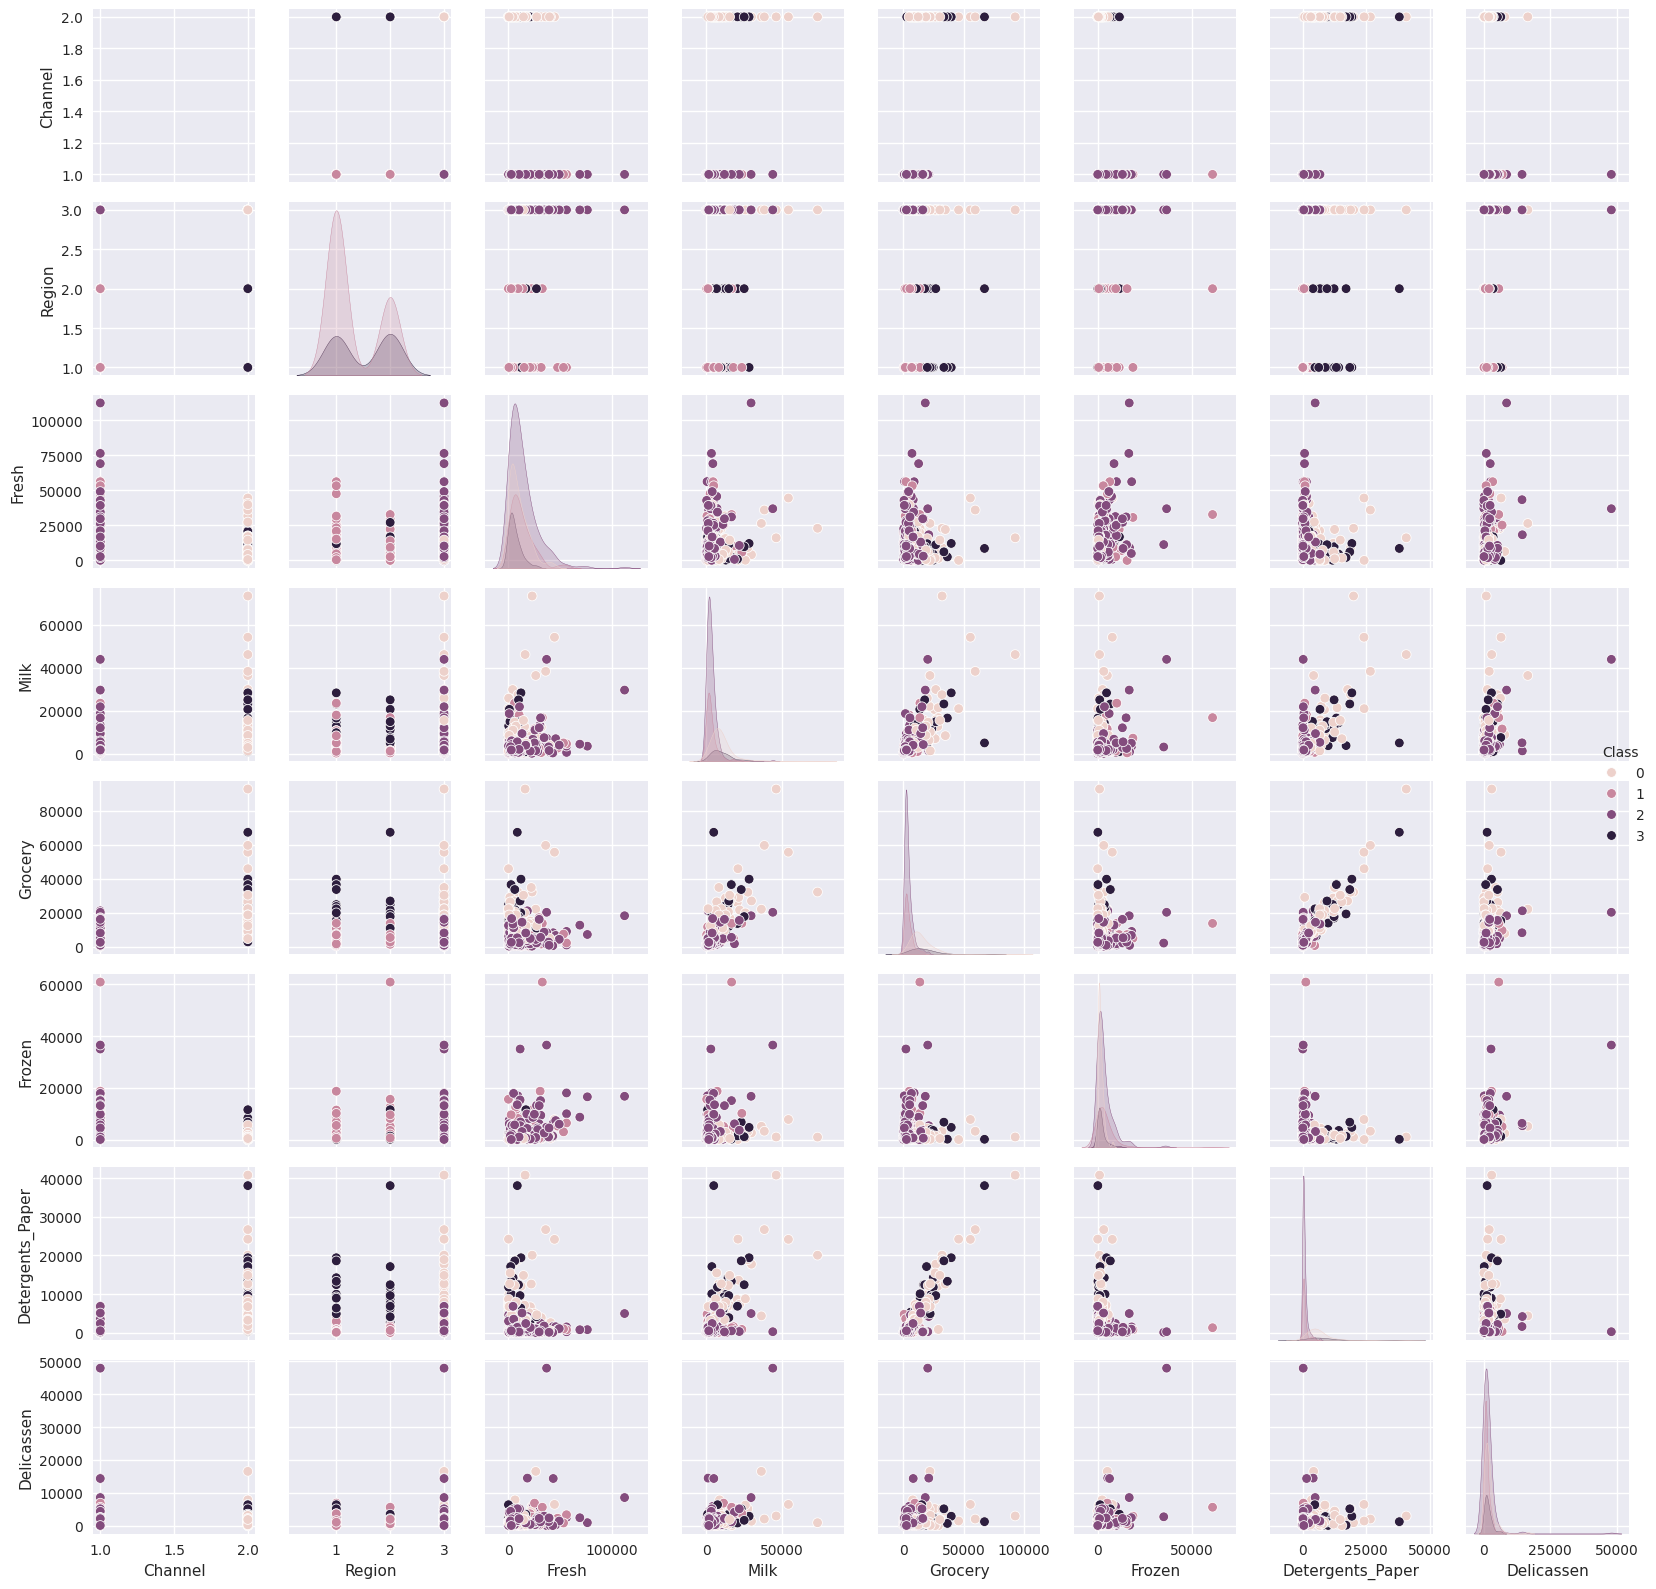

In [20]:
sns.pairplot(X0.assign(Class=pred_k), height=2, hue="Class")
plt.tight_layout()
plt.show()

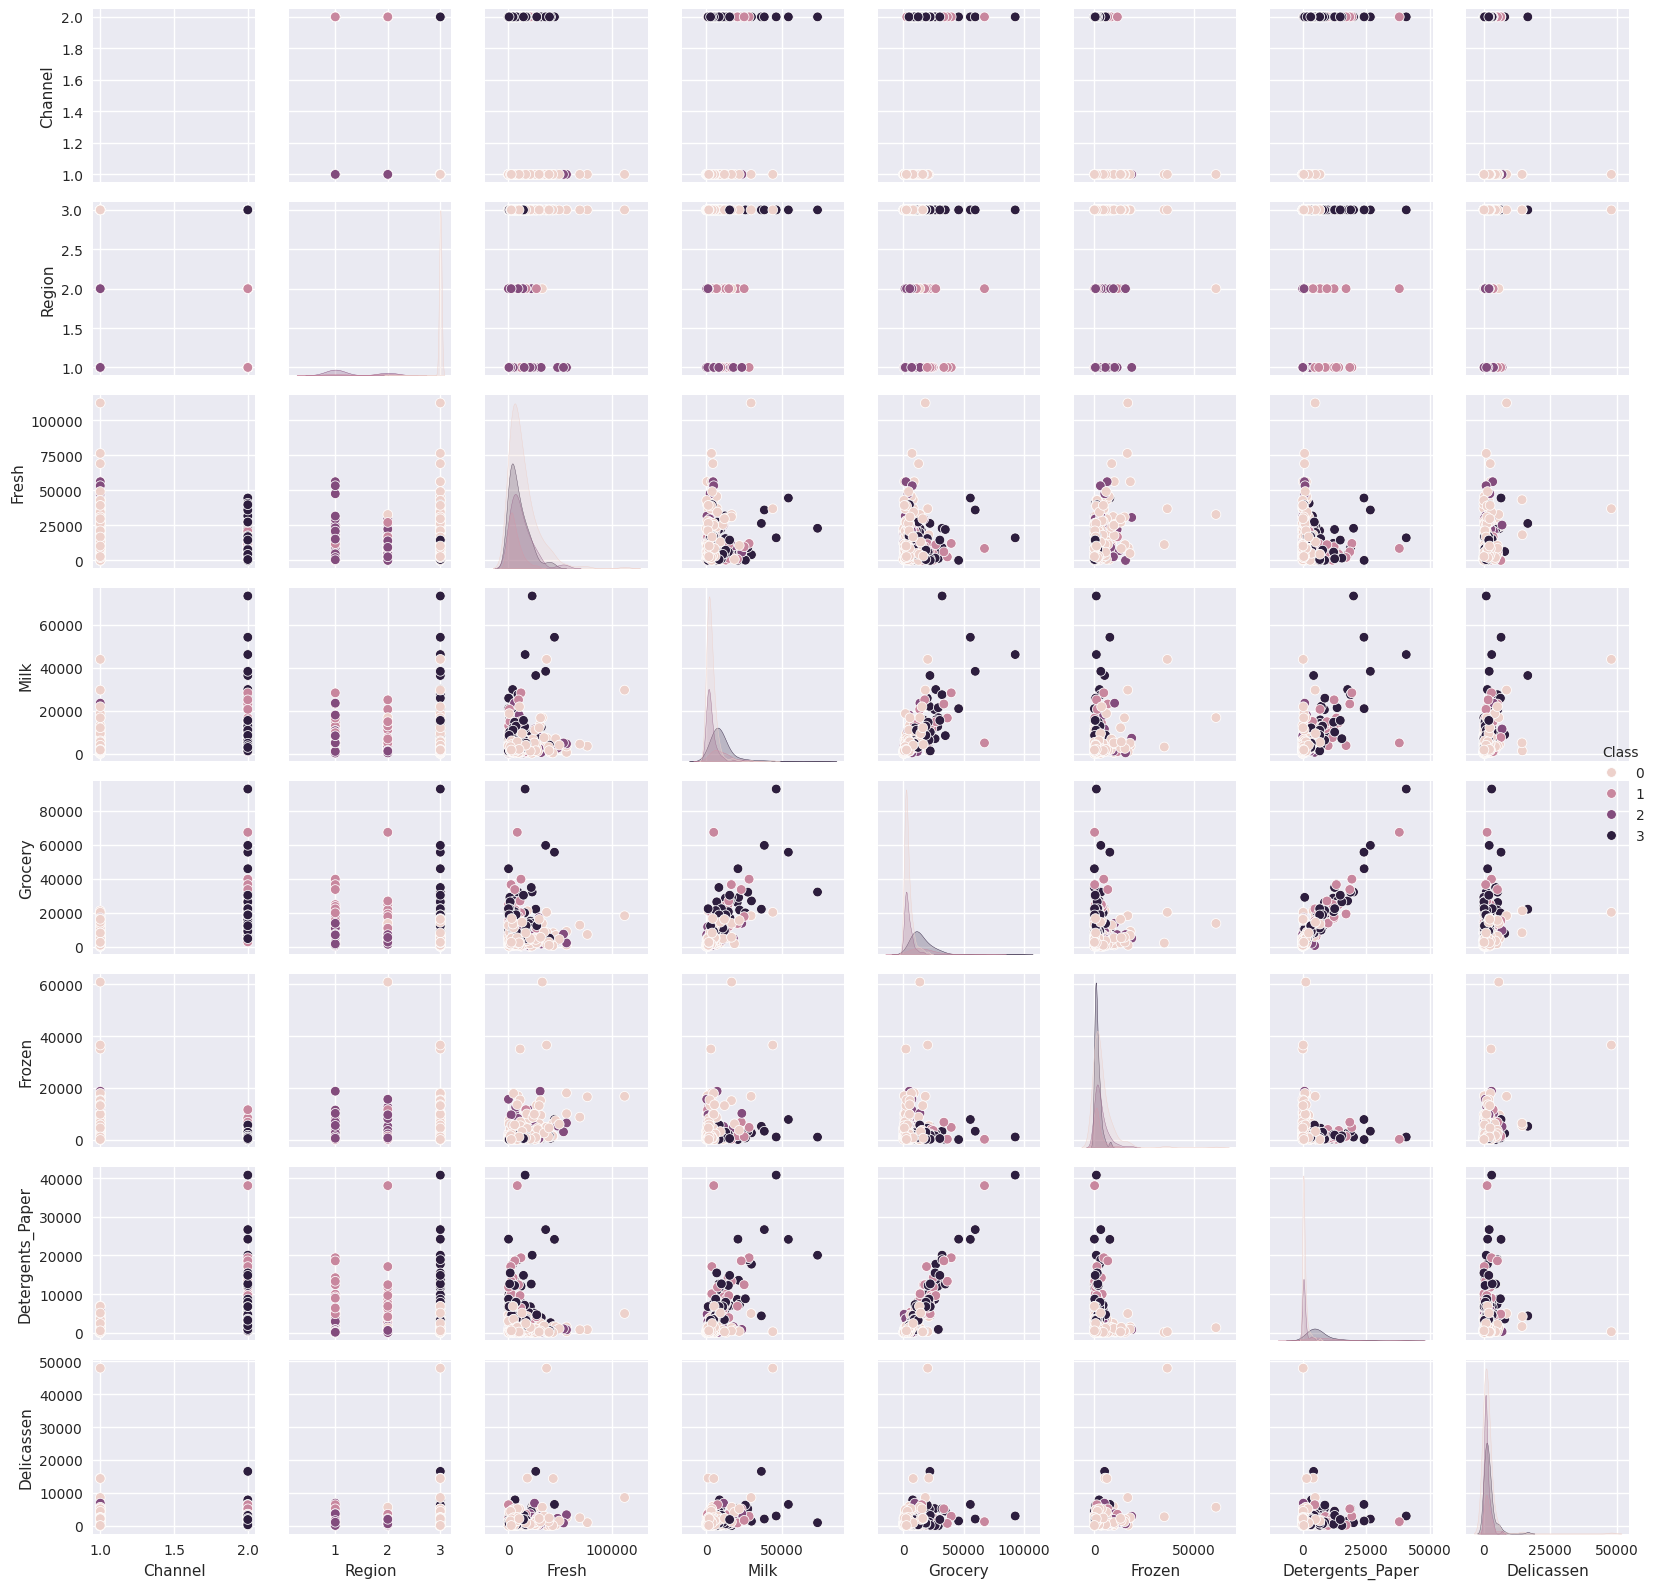

In [21]:
sns.pairplot(X0.assign(Class=pred_clu), height=2, hue="Class")
plt.tight_layout()
plt.show()

### Comments


The solution with the Agglomerative Clustering in this case provides a result very similar to that of kmeans.

It is interesting to compare more deeply the results of the two clustering models. 

The function `pair_confusion_matrix` computes the number of pairs of objects that are in the same clusters or in different clusters in two different clustering schemes. 

The result is given in a 2x2 matrix, the smaller the numbers out of the main diagona, the better the match.

For easier readability, we divide all the elements of the matrix by the sum of all the elements of the matrix, in this way, the matrix elements are normalized to 1.

In [22]:
from sklearn.metrics import pair_confusion_matrix

matrix = pair_confusion_matrix(pred_k, pred_clu)
divided = matrix / np.sum(matrix)
display(divided)

array([[0.66625595, 0.00218472],
       [0.00089045, 0.33066888]])

A short indicator of the match percentage can be optained as a sum of the elements of the main diagonal.

In [23]:
perc = (divided[0][0] + divided[1][1]) * 100
print("Percent of match between the two clustering: {:.2f}%".format(perc))

Percent of match between the two clustering: 99.69%


## DBSCAN

In [24]:
from sklearn.cluster import DBSCAN

In [25]:
dbscan = DBSCAN(n_jobs=-1, min_samples=5)
pred_dbscan = dbscan.fit_predict(X_pt)

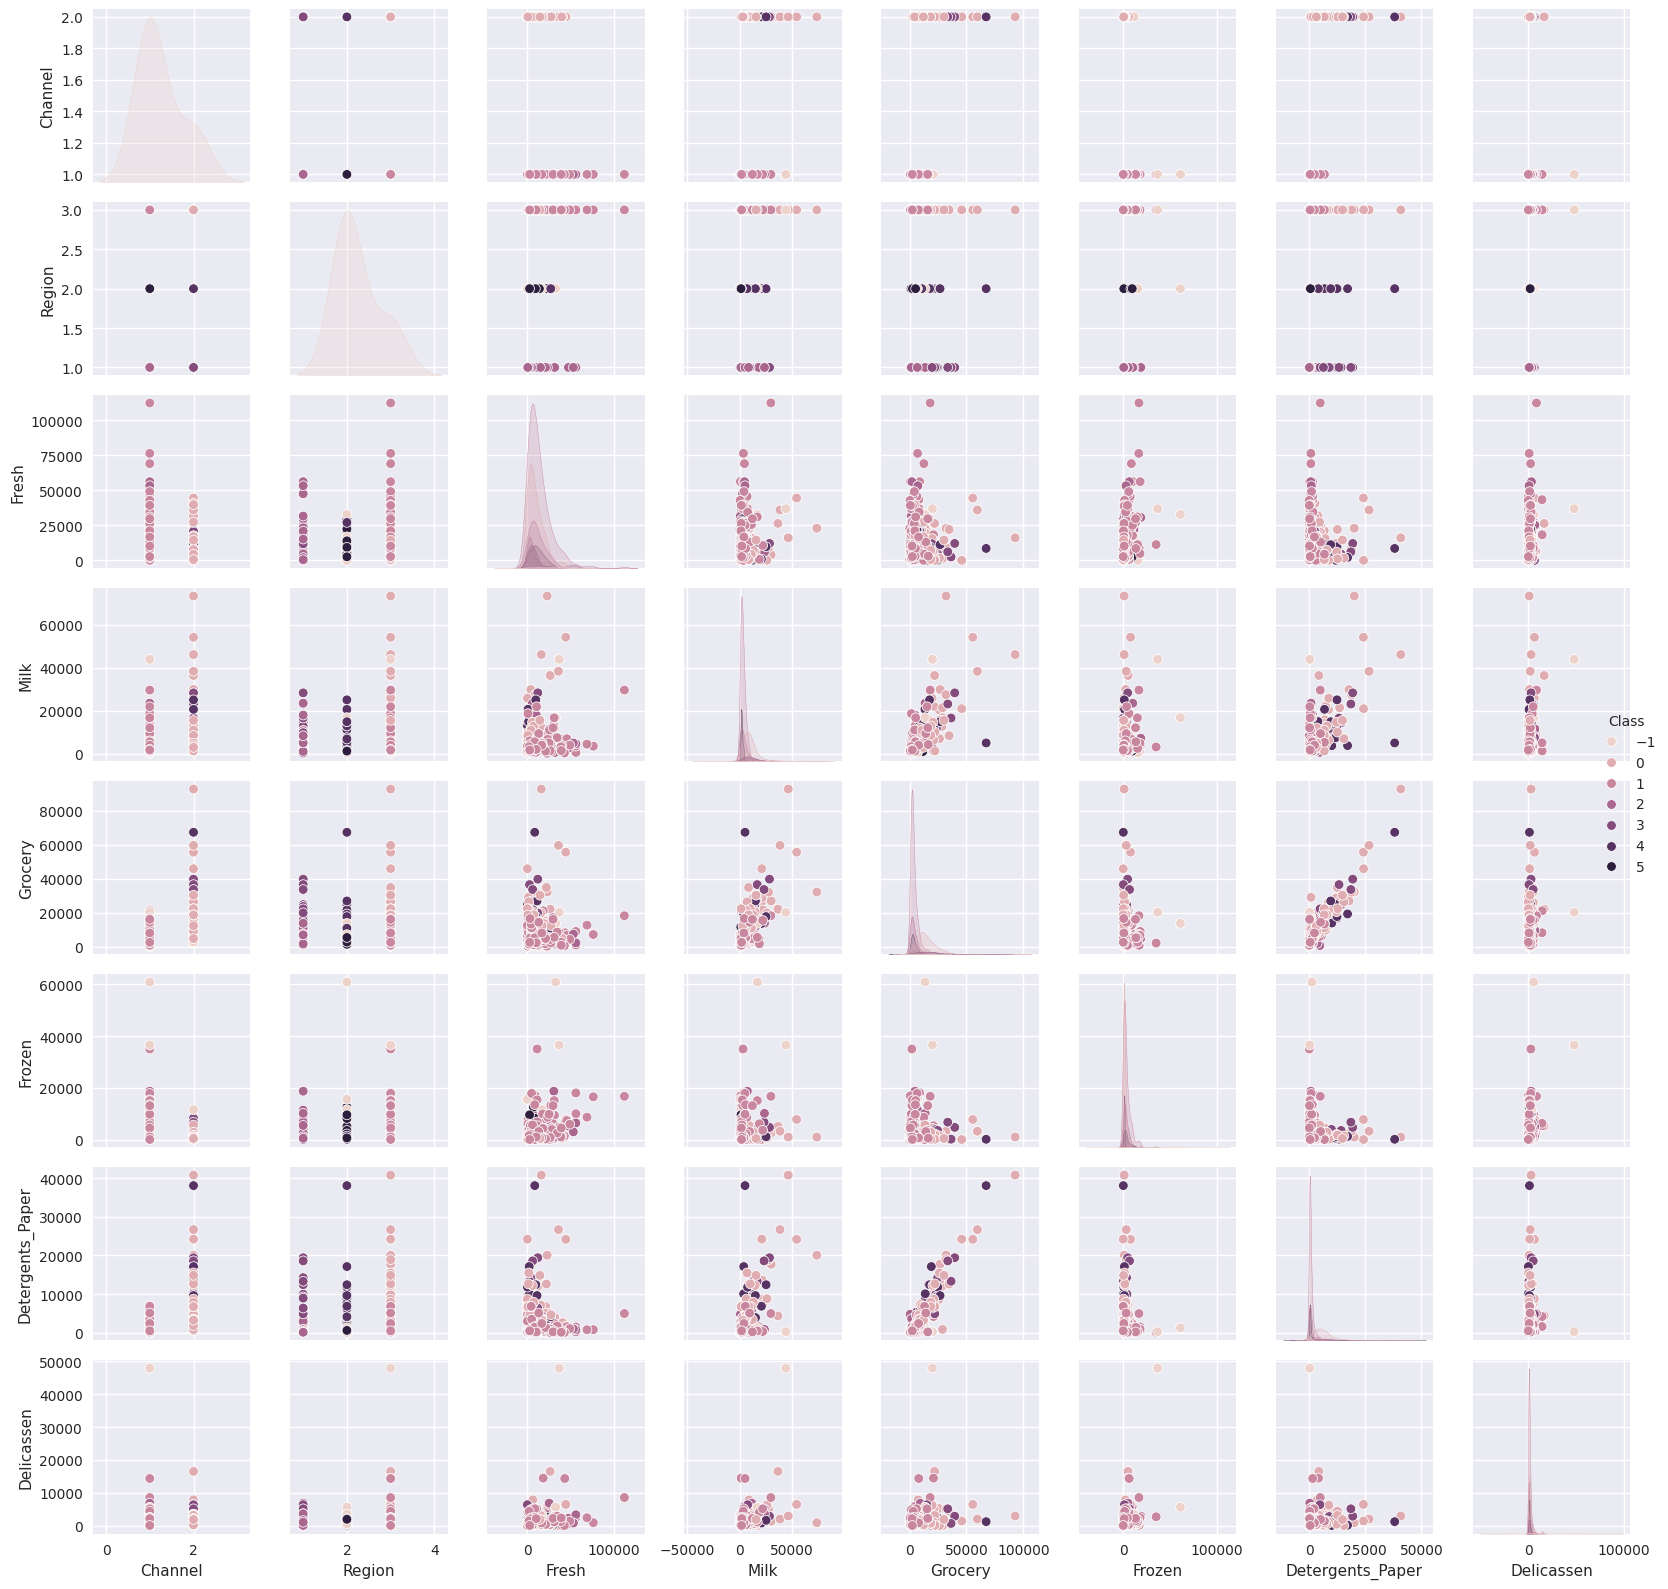

In [26]:
sns.pairplot(X0.assign(Class=pred_dbscan), height=2, hue="Class")
plt.tight_layout()
plt.show()

Show the distribution of data in the clusters

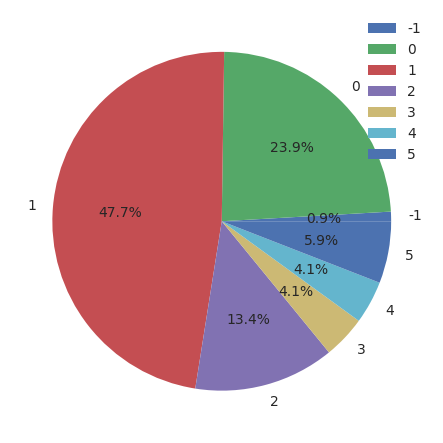

In [27]:
plt.pie(
    np.unique(pred_dbscan, return_counts=True)[1],
    labels=np.unique(pred_dbscan, return_counts=True)[0],
    autopct="%1.1f%%",
)
plt.legend()
plt.show()

### 5. Find the best parameters using `ParameterGrid`

prepare the dictionary of the parameter ranges and produce the list of parameter settings to test with the function `ParameterGrid`

In [36]:
param_grid = [
    {
        "eps": [1000**exp for exp in range(51, 571, 10)],
        "min_samples": [*range(2, 10, 1)],
    }
]

Arrange DBSCAN results in a dataframe, for easier presentation and filtering

`dbscan_out = pd.DataFrame(columns =  ['eps','min_samples','n_clusters','silhouette', 'unclust%'])`

- for each parameter setting

In [29]:
dbscan_out = pd.DataFrame(
    columns=["eps", "min_samples", "n_clusters", "silhouette", "unclust%"]
)

### 6. Observe  
- Observe visually the most promising combination of parameters reproducing the same number of clusters of the previous experiments 
- fit and predict the cluster labels and show a pairplot

Show the cluster sizes

## Silhouette plots

Use the function `plot_silhouette` contained in the module `plot_silhouette_w_mean` (provided with the notebook) and from `sklearn.metrics` import the function `silhouette_samples` providing the silhouette score for each sample

`from plot_silhouette_w_mean import plot_silhouette  # python script provided separately`

Hint: use `help(plot_silhouette)` for the meaning of the parameters

Hint: for DBSCAN you should exclude the rows of noise

In [ ]:
from plot_silhouette_w_mean import plot_silhouette  # python script provided separately

## Optional - Comparison with __boxplots__

For each of the clustering schemes show how the attribute values are distributed in the clusters

## Control questions
1. Repeat the experiments without the data transformations and comment the result
1. Repeat the final fittings with the numbers of clusters immediately before and after the chosen values and comment the results